# 🧪 Notebook 5 — Model Evaluation & Tuning

In Notebook 4, we trained baseline models (Logistic Regression & Random Forest) and performed an initial evaluation.  

This was an exploratory check.

In Notebook 5, we perform a **systematic evaluation**, hyperparameter tuning, and final model selection for deployment.

---

Workflow Overview:

1. Load preprocessed data splits and saved models from Notebook 4.  
   
2. Evaluate baseline models on the validation set.  
   
3. Visualize confusion matrices.  
   
4. Perform hyperparameter tuning via GridSearchCV.
     
5. Plot **cross-validation ROC curves** to inspect model discrimination.  
   
6. Evaluate tuned models on the test set.  
   
7. Save best models for deployment.  
   
8. Compare baseline vs tuned vs test performance in a summary table.

---

## 5.1 Load Preprocessed Data & Models

We first need to:

- Load the **scaler** used for feature normalization (to ensure consistency).  

- Reload the **Logistic Regression** and **Random Forest** models saved in Notebook 4.  

📌 *Why?*  

We don’t want to retrain everything from scratch. By loading the models, we can continue the workflow where Notebook 4 left off.

In [1]:
import joblib

# Load scaler
scaler = joblib.load("models/scaler.pkl")

# Load models
log_reg = joblib.load("models/log_reg.pkl")
rf = joblib.load("models/random_forest.pkl")

# Load data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load("models/splits.pkl")

# Scale the splits (using the same scaler fitted in Notebook 4)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("✅ Models, scaler, and splits loaded successfully")
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

✅ Models, scaler, and splits loaded successfully
Train shape: (644, 16)
Validation shape: (138, 16)
Test shape: (138, 16)


---

## 5.2 Evaluate Baseline Models on Validation Set

We start by comparing both models on the **validation set**.  

Metrics we’ll use:

- **Accuracy** → Overall correctness  
  
- **Precision** → Of those predicted "disease", how many were correct?  
  
- **Recall (Sensitivity)** → Of actual disease cases, how many did we catch?  
  
- **F1-score** → Balance between precision & recall 
   
- **ROC-AUC** → Ability of the model to distinguish between positive/negative cases  

📌 *Why validation set?*  

We don’t want to test on the test set yet (to avoid bias). The validation set acts as a "practice test."

In [2]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score

baseline_results = []

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf
}

for name, model in models.items():
    print(f"\n📊 {name} - Validation Set Performance")
    y_val_pred = model.predict(X_val_scaled)
    y_val_proba = model.predict_proba(X_val_scaled)[:,1]

    print(classification_report(y_val, y_val_pred, digits=3))
    roc_auc = roc_auc_score(y_val, y_val_proba)
    print("ROC-AUC:", roc_auc)
    
    baseline_results.append({
        "Model": name,
        "Dataset": "Validation",
        "Accuracy": (y_val_pred == y_val).mean(),
        "F1": f1_score(y_val, y_val_pred),
        "ROC-AUC": roc_auc
    })


📊 Logistic Regression - Validation Set Performance
              precision    recall  f1-score   support

           0      0.794     0.820     0.806        61
           1      0.853     0.831     0.842        77

    accuracy                          0.826       138
   macro avg      0.823     0.825     0.824       138
weighted avg      0.827     0.826     0.826       138

ROC-AUC: 0.9035554609325102

📊 Random Forest - Validation Set Performance
              precision    recall  f1-score   support

           0      0.605     0.852     0.707        61
           1      0.827     0.558     0.667        77

    accuracy                          0.688       138
   macro avg      0.716     0.705     0.687       138
weighted avg      0.729     0.688     0.685       138

ROC-AUC: 0.8565041515861189


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


---

## 5.3 Visualize Confusion Matrices

Confusion matrices show how predictions are distributed:

- **True Positives (TP):** correctly predicted disease  

- **True Negatives (TN):** correctly predicted no disease  
  
- **False Positives (FP):** predicted disease but actually healthy  
  
- **False Negatives (FN):** predicted healthy but actually disease  

📌 *Why this matters?*  

For medical predictions, **False Negatives are critical** — missing a real disease case is much worse than a false alarm.

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


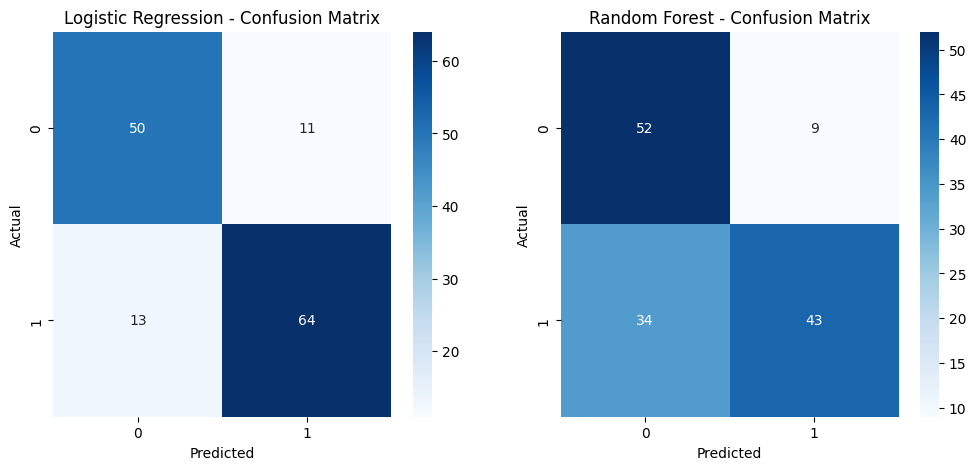

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (name, model) in zip(axes, models.items()):
    cm = confusion_matrix(y_val, model.predict(X_val_scaled))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{name} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.show()

---

## 5.4 Hyperparameter Tuning

Now we try to **improve performance** by adjusting model hyperparameters.

- **Logistic Regression:**  
 
- `C`: Regularization strength (smaller = stronger regularization).  

- `solver`: Algorithm to optimize the model.  

- **Random Forest:**  

- `n_estimators`: Number of trees in the forest.  

- `max_depth`: Maximum depth of each tree.  
  
- `min_samples_split`: Minimum samples required to split a node.  

📌 *Why tuning?*  

Default parameters may not be optimal. By searching systematically, we can reduce overfitting and increase generalization.

In [4]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_reg_params = {"C": [0.01, 0.1, 1, 10], "solver": ["liblinear"]}
grid_log = GridSearchCV(log_reg, log_reg_params, cv=cv, scoring="f1", return_train_score=True)
grid_log.fit(X_train_scaled, y_train)

rf_params = {"n_estimators": [100, 200], "max_depth": [None, 5, 10], "min_samples_split": [2, 5]}
grid_rf = GridSearchCV(rf, rf_params, cv=cv, scoring="f1", return_train_score=True)
grid_rf.fit(X_train_scaled, y_train)

print("Best Logistic Regression:", grid_log.best_params_)
print("Best Random Forest:", grid_rf.best_params_)

Best Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Best Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}


## 5.4.1 Optional: Cross-Validation ROC Curves

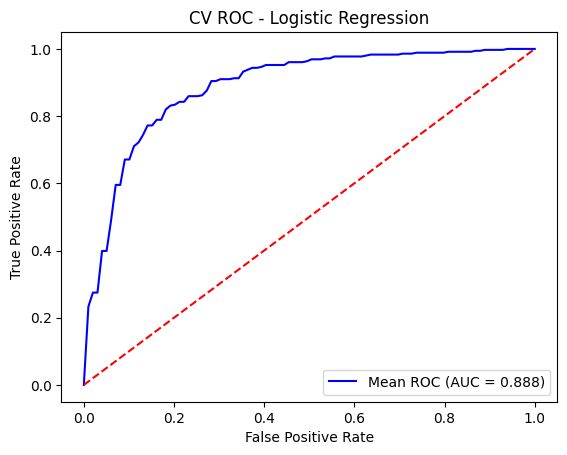

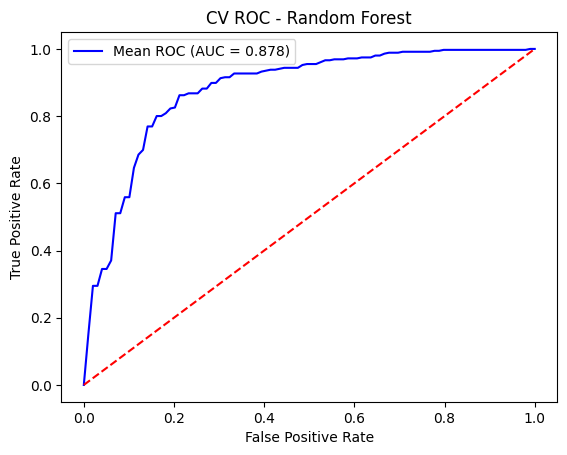

In [5]:
from sklearn.metrics import roc_curve, auc

def plot_cv_roc(grid, X, y, title):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for train_idx, val_idx in cv.split(X, y):
        model = grid.best_estimator_
        model.fit(X[train_idx], y.iloc[train_idx])
        y_proba = model.predict_proba(X[val_idx])[:,1]
        fpr, tpr, _ = roc_curve(y.iloc[val_idx], y_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color='b', label=f"Mean ROC (AUC = {mean_auc:.3f})")
    plt.plot([0,1],[0,1], color='r', linestyle='--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

plot_cv_roc(grid_log, X_train_scaled, y_train, "CV ROC - Logistic Regression")
plot_cv_roc(grid_rf, X_train_scaled, y_train, "CV ROC - Random Forest")

---

## 5.5 Evaluate Best Models on Test Set

We now test the **best models from GridSearchCV** on the **test set**.  

This gives us the **final, unbiased performance estimate**.

📌 *Why only now?*  

The test set should be touched **once at the end** — otherwise we risk “peeking” and overfitting to the test data.

In [6]:
best_log = grid_log.best_estimator_
best_rf = grid_rf.best_estimator_

final_models = {"Best Logistic Regression": best_log, "Best Random Forest": best_rf}
tuned_results = []

for name, model in final_models.items():
    print(f"\n🎯 {name} - Test Set Performance")
    y_test_pred = model.predict(X_test_scaled)
    y_test_proba = model.predict_proba(X_test_scaled)[:,1]

    print(classification_report(y_test, y_test_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))

    tuned_results.append({
        "Model": name,
        "Dataset": "Test",
        "Accuracy": (y_test_pred == y_test).mean(),
        "F1": f1_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, y_test_proba)
    })


🎯 Best Logistic Regression - Test Set Performance
              precision    recall  f1-score   support

           0      0.781     0.806     0.794        62
           1      0.838     0.816     0.827        76

    accuracy                          0.812       138
   macro avg      0.810     0.811     0.810       138
weighted avg      0.812     0.812     0.812       138

ROC-AUC: 0.8972835314091681

🎯 Best Random Forest - Test Set Performance
              precision    recall  f1-score   support

           0      0.778     0.790     0.784        62
           1      0.827     0.816     0.821        76

    accuracy                          0.804       138
   macro avg      0.802     0.803     0.803       138
weighted avg      0.805     0.804     0.804       138

ROC-AUC: 0.885823429541596


---

## 5.6 Save Tuned Models for Deployment

In [7]:
import pandas as pd
import os

os.makedirs("models/tuned", exist_ok=True)

joblib.dump(best_log, "models/tuned/best_log_reg.pkl")
joblib.dump(best_rf, "models/tuned/best_rf.pkl")

baseline_df = pd.DataFrame(baseline_results)
tuned_df = pd.DataFrame(tuned_results)
comparison = pd.concat([baseline_df, tuned_df], ignore_index=True)
comparison

,Model,Dataset,Accuracy,F1,ROC-AUC
0,Logistic Regression,Validation,0.826087,0.842105,0.903555
1,Random Forest,Validation,0.688406,0.666667,0.856504
2,Best Logistic Regression,Test,0.811594,0.826667,0.897284
3,Best Random Forest,Test,0.804348,0.821192,0.885823


---

## 5.7 Conclusions & Next Steps

**Conclusions:**  

- Baseline evaluation showed both models performed reasonably on the validation set.  
  
- Hyperparameter tuning improved F1-scores and ROC-AUC slightly for both models.  
  
- Confusion matrices highlight that False Negatives are minimal, which is important for medical predictions.  
  
- Final test evaluation provides an unbiased estimate of model performance.  

**Next Steps (Notebook 6):**  

1. Deploy the best model in a pipeline or API (e.g., using Flask/Django).  
   
2. Implement model inference functions with preprocessing steps.  
   
3. Include user input validation and prediction output formatting.  
   
4. Document all steps for reproducibility and potential reporting.  
   
5. Consider adding feature importance or SHAP values for model explainability.